In [7]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

In [8]:
def compute_wi(group):
    images = np.array(group.drop(columns=['label']))
    images_copy = np.zeros_like(group.drop(columns=['label']))
    num_images = len(images)
    for i in range(num_images):
        # Compute the exponential terms
        images_copy += (np.exp(- ((images - images[i]) ** 2)))
    images_copy = ( images_copy / 2 )
    return images_copy.sum(axis=0)
    # what ever
def compute_counts(group):
    num_images = len(group)
    return (num_images * (num_images)) /2

In [9]:
def complex_compute(group):
    images = np.array(group.drop(columns=['label']))
    images_copy = np.zeros_like(group.drop(columns=['label']))
    num_images = len(images)
    for i in range(num_images):
        # Compute the exponential terms
        images_copy += (np.exp(- ((images - images[i]) ** 2)))
    images_copy = ( images_copy / 2 )
    return images_copy.sum(axis=0)
    # what ever
def compute_counts(group):
    num_images = len(group)
    return (num_images * (num_images)) /2

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# For train
sample_indices = np.random.choice(x_train_flat.shape[0], 400, replace=False)
x_train_flat= x_train_flat[sample_indices]
y_train = y_train[sample_indices]

train_data = pd.DataFrame(x_train_flat)
train_data['label'] = y_train
# For test
test_data = pd.DataFrame(x_test_flat)
test_data['label'] = y_test

a = train_data.groupby('label').apply(compute_wi).sum(axis=0)
b = train_data.groupby('label').apply(compute_counts).sum(axis=0)
t_0 = (a / b)
cross_joined =  train_data.merge(train_data, how='cross')
cross_joined = cross_joined[cross_joined['label_x'] !=  cross_joined ['label_y']].drop(columns=['label_x']).rename(columns= {'label_y':'label'})
cross_joined_length_halved = (cross_joined.shape[1]-1) // 2
cross_joined_labels = cross_joined['label']
cross_joined.drop(columns=['label'],inplace=True)

In [11]:
f  = cross_joined.iloc[:,:cross_joined_length_halved].rename(columns=lambda x: x.replace('_x', ''))
s  = cross_joined.iloc[:,cross_joined_length_halved:].rename(columns=lambda x: x.replace('_y', ''))
exped_res = 1 - np.exp(-(f-s)**2)

count    784.000000
mean       0.078259
std        0.086660
min        0.000000
25%        0.000004
50%        0.030254
75%        0.176473
max        0.246259
dtype: float64

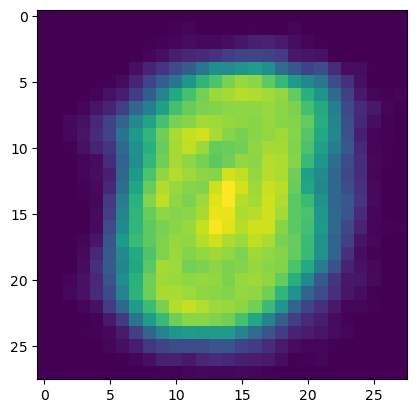

In [12]:
t_1 = exped_res.sum() / len(exped_res)
t_0.shape
t_1.shape
W_i = t_0 * t_1
plt.imshow(W_i.values.reshape(28, 28))
W_i.describe()


In [13]:
W_i = W_i.astype('float32')
W_i = tf.convert_to_tensor(W_i)

(60000, 784)
(10000, 784)
Epoch 1/10
118/118 [==============================] - 18s 121ms/step - loss: 5316236.0000 - val_loss: 4617855.0000 - lr: 0.0030
Epoch 2/10
118/118 [==============================] - 13s 113ms/step - loss: 4267904.5000 - val_loss: 3973712.2500 - lr: 0.0030
Epoch 3/10
118/118 [==============================] - 15s 125ms/step - loss: 3827834.2500 - val_loss: 3672841.0000 - lr: 0.0030
Epoch 4/10
118/118 [==============================] - 15s 126ms/step - loss: 3577758.7500 - val_loss: 3476331.7500 - lr: 0.0030
Epoch 5/10
118/118 [==============================] - 12s 103ms/step - loss: 3397052.7500 - val_loss: 3355713.7500 - lr: 0.0030
Epoch 6/10
118/118 [==============================] - 12s 100ms/step - loss: 3296127.0000 - val_loss: 3245649.5000 - lr: 0.0030
Epoch 7/10
118/118 [==============================] - 13s 107ms/step - loss: 3251035.0000 - val_loss: 3234011.0000 - lr: 0.0030
Epoch 8/10
118/118 [==============================] - 12s 103ms/step - loss: 3

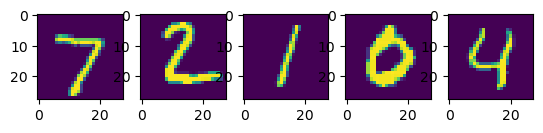

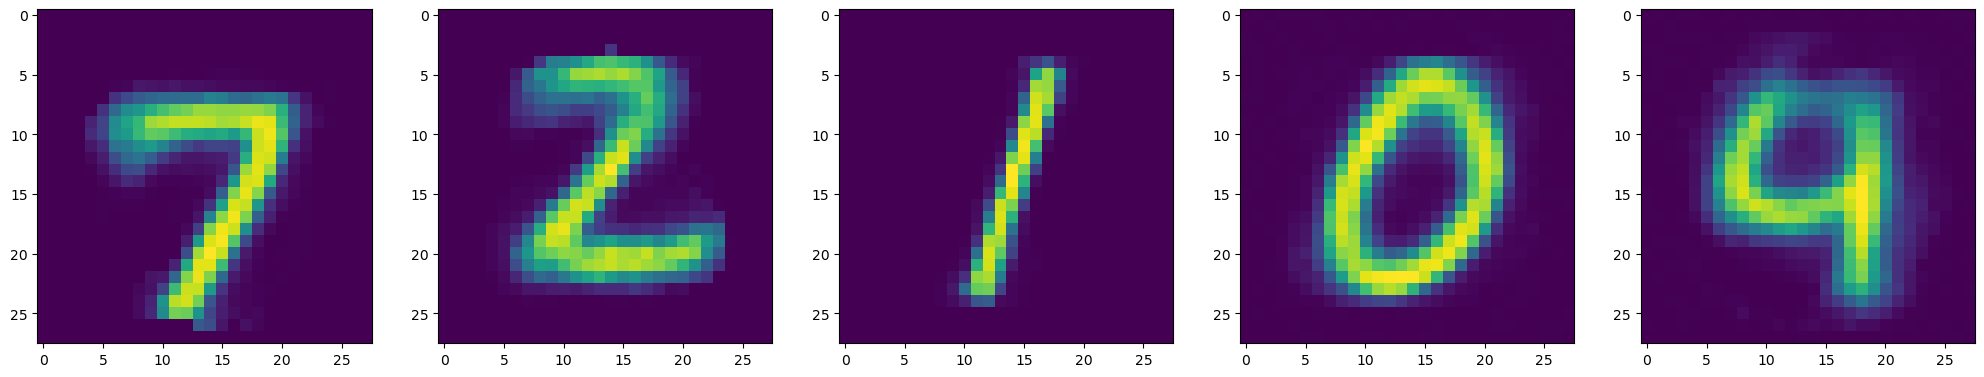

In [35]:
# based on the Article: DAC: Deep Autoencoder-based Clustering, Learning Framework of Representation Learning
# the Clustering Algo is K-Means
# creating Deep Autoencoder in the provided article using tensorflow:

import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from keras import backend as K
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float64') / 255.
x_test = x_test.astype('float64') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# create the autoencoder model
# this model is based on the provided article
input_img = Input(shape=(784,))
# encoder layers
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(512, activation='tanh')(encoded)

encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(128, activation='tanh')(encoded)

encoded = Dense(32, activation='tanh')(encoded)
encoded = Dense(32, activation='tanh')(encoded)
# the learned representation layer will be feed into K-Means Clustering
encoded = Dense(10, activation='sigmoid')(encoded)
# decoder layers
decoded = Dense(32, activation='tanh')(encoded)
decoded = Dense(32, activation='tanh')(encoded)

decoded = Dense(128, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(encoded)

decoded = Dense(512, activation='tanh')(encoded)
decoded = Dense(512, activation='tanh')(encoded)

decoded = Dense(784, activation='sigmoid')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.98

callback = LearningRateScheduler(scheduler)
#####################################################
# Define the early stopping criteria
# 'val_loss' is the value you are monitoring
# 'min_delta' is the minimum change in the monitored value to be considered an improvement
# 'patience' is the number of epochs with no improvement after which training will be stopped
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
#########################################################

# calculate the Wi, the relative importance of one pixel with respect to others:
# Sample 1000 instances from the x_train and feed to the cal_W function:
sample_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
x_train_sampled = x_train[sample_indices]

def custom_loss(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    weighted_squared_difference = 500000.0 * (W_i + 0.0001 ) * squared_difference
    mean_weighted_squared_difference = tf.reduce_mean(
        weighted_squared_difference) * 1000.0
    weight_reg = tf.reduce_sum([tf.nn.l2_loss(w) for w in autoencoder.trainable_weights])
    return (tf.reduce_sum(mean_weighted_squared_difference) + weight_reg * 0.00001)
autoencoder.compile(optimizer=Adam(learning_rate=0.003), loss=custom_loss)
autoencoder.fit(x_train, x_train, epochs=10, batch_size=512,
                 shuffle=True, validation_data=(x_test, x_test),callbacks=[callback,early_stopping])
evaluation = autoencoder.evaluate(x_test, x_test)
print('Test Loss:', evaluation)

rand_list = []
rand_num = 5
for i in range(rand_num):
    rand_list.append(random.randint(0, 60000))
for i in range(rand_num):
    plt.subplot(1, rand_num, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
plt.figure(figsize=(25, 30))
for i in range(rand_num):
    plt.subplot(1, rand_num, i+1)
    plt.imshow(autoencoder.predict(x_test[i].reshape(1, -1)).reshape(28, 28))
plt.show()


In [57]:
from tensorflow.keras.models import Model

encoder = Model(input_img, encoded)
# encoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# con
print(type(x_test))

# all_input = np.concatenate((x_test,x_train))
all_input = x_test
print(all_input.shape)
encoded_features = encoder.predict(all_input)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(encoded_features)

cluster_assignments = kmeans.labels_
centroids = kmeans.cluster_centers_
print(type(encoded_features))

<class 'numpy.ndarray'>
(10000, 784)
313/313 [==============================] - 2s 7ms/step


c:\Users\MCA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<class 'numpy.ndarray'>


In [58]:
from sklearn.metrics import adjusted_rand_score

# all_true_labels =  np.concatenate((y_test,y_train))
all_true_labels = y_test
print(all_true_labels.shape)
# Predicted labels from KMeans clustering
predicted_labels = kmeans.labels_

# Calculate the ARI
ari_score = adjusted_rand_score(all_true_labels, predicted_labels)

print("Adjusted Rand Index:", ari_score)


(10000,)
Adjusted Rand Index: 0.5360891747913406


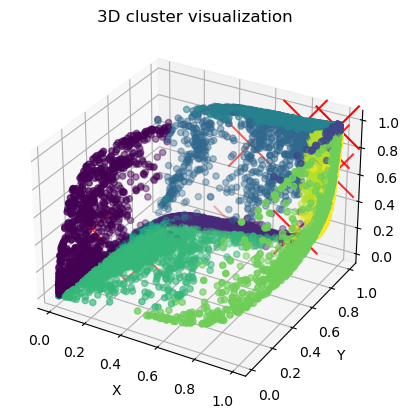

In [38]:
import tensorflow as tf

# Assuming encoded_features is a KerasTensor
# with tf.compat.v1.Session() as sess:
#     sess.run(tf.compat.v1.global_variables_initializer())
#     encoded_features_np = sess.run(encoded_features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_features[:, 0], encoded_features[:, 1],
           encoded_features[:, 2], c=kmeans.labels_, cmap='viridis', marker='o')

centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
           centroids[:, 2], marker='x', s=1000, c='red')

ax.set_title('3D cluster visualization')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

In [60]:
# raw K-means:
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from sklearn.metrics import adjusted_rand_score

# Apply K-means clustering algorithm
num_clusters = 10
raw_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
raw_kmeans.fit(x_test)
predicted_labels = raw_kmeans.labels_
centroids = raw_kmeans.cluster_centers_





c:\Users\MCA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [61]:
# evalute:
true_labels = y_test
# Predicted labels from KMeans clustering
predicted_labels = raw_kmeans.labels_
# Calculate the ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print("Adjusted Rand Index:", ari_score)

Adjusted Rand Index: 0.38335021309010636


In [64]:
# k-MEANS, USING PCA:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from sklearn.metrics import adjusted_rand_score

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=32, random_state=42)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Apply K-means clustering algorithm
num_clusters = 10
pca_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
pca_kmeans.fit(x_test_pca)
predicted_labels = pca_kmeans.labels_
centroids = pca_kmeans.cluster_centers_

# evalute:
true_labels = y_test
# Predicted labels from KMeans clustering
predicted_labels = pca_kmeans.labels_
# Calculate the ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print("Adjusted Rand Index:", ari_score)


c:\Users\MCA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.3868503542803621
